In [2]:
from sympy.abc import s, z
import sympy as sp
import numpy as np
from control import matlab as m
from utils.units import u
from utils.units.sympy_helpers import without_units, split_unit_form as split_unit
from pathlib import Path
from IPython.display import display
from utils.ctrl import sys_deu

def usubs(var, val, expr):
    return without_units(expr,
        lambda dummify, expr: expr.subs(
            var, dummify(val)))

def var_in(var, unit, expr):
    return usubs(var, var/unit, expr)

out_dir = Path("./out") / "parcial1_rec"

In [3]:
gp = 157/(s*(.2*s+1))*14*0.019108
display(gp)
gp = var_in(s, u.rad/u.s, gp)
gp

41.999384/(s*(0.2*s + 1))

41.999384*radian/(second*s*(1 + 0.2*second*s/radian))

In [4]:
gc = .28442*(s+6.65)/(s+14.05)
display(gc)
gc = var_in(s, u.rad/u.s, gc)
gc

(0.28442*s + 1.891393)/(s + 14.05)

(1.891393 + 0.28442*second*s/radian)/(14.05 + second*s/radian)

In [5]:
from utils.ratpolys import ratpoly_zpk_form

kl, al, bl, dt = sp.symbols("K_l a_l b_l T")
s_bi = 2/dt*(z-1)/(z+1)
gc_lead = kl*(s+al)/(s+bl)

gc_lead.subs(
    s, s_bi
) |> ratpoly_zpk_form$(?, z)

(K_l*T*a_l + 2*K_l)*((z + (T*a_l - 2)/(T*a_l + 2))/(z + (T*b_l - 2)/(T*b_l + 2)))/(T*b_l + 2)

In [6]:
from utils.units import basis
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=7193693603967046159), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [7]:
from utils.ctrl import expr2sys
my_sys_deu = sys_deu$(?, nu, 1, 1)

def my_expr2sys(expr, var, tf=None):
    return expr2sys(nu.to_numeric(expr, as_expr=True), var, tf)

gp_tf = my_expr2sys(gp, s)
gc_tf = my_expr2sys(gc, s)
gcl_tf = m.feedback(gc_tf*gp_tf)

In [8]:
from utils.ctrl import nu_stepinfo
ct_stepinfo = nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_tf))

nr = 10
dt_ = ct_stepinfo["RiseTime"]/nr
dt_

0.0287782962900297*second

In [9]:
gc_d = usubs(dt, dt_, usubs(s, s_bi, gc))
gc_d

(1.891393 + 19.7662847816699*(z - 1)/(radian*(z + 1)))/(14.05 + 69.4968173182964*(z - 1)/(radian*(z + 1)))

In [10]:
gc_dtf = my_expr2sys(gc_d, z).minreal()
gc_dtf

TransferFunction(array([ 0.25922804, -0.2139506 ]), array([ 1.        , -0.66366163]), True)

In [11]:
gp_dtf = m.c2d(gp_tf, nu[dt_])
gp_dtf |> my_sys_deu

TransferFunction(array([0.08293366, 0.07905031]), array([ 1.        , -1.86598172,  0.86598172]), 0.02877829629002968)

In [12]:
gcl_dtf = m.feedback(gc_dtf*gp_dtf, 1)
gcl_dtf |> my_sys_deu

TransferFunction(array([ 0.02149873,  0.00274835, -0.01691286]), array([ 1.        , -2.50814462,  2.10711055, -0.5916317 ]), 0.02877829629002968)

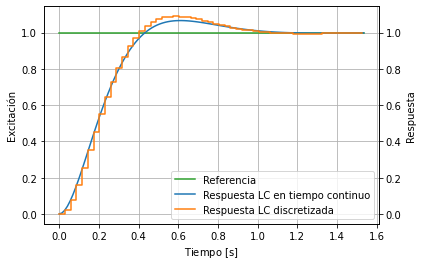

In [13]:
from utils.ctrlsys import step, zoh_stairs
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

plot_step(gcl_tf, label="Respuesta LC en tiempo continuo")
plot_step(gcl_dtf, label="Respuesta LC discretizada")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")

fig.savefig(out_dir / "1p3_resp.svg")

In [14]:
gzohinv = 2*z/(z+1)
gzohinv_dtf = my_expr2sys(gzohinv, z)
gzohinv_dtf

TransferFunction(array([2, 0]), array([1, 1]), True)

In [15]:
gcc_dtf = gc_dtf * gzohinv_dtf
gcc_dtf

TransferFunction(array([ 0.51845608, -0.4279012 ,  0.        ]), array([ 1.        ,  0.33633837, -0.66366163]), True)

In [16]:
gclc_dtf = m.feedback(gp_dtf * gcc_dtf)

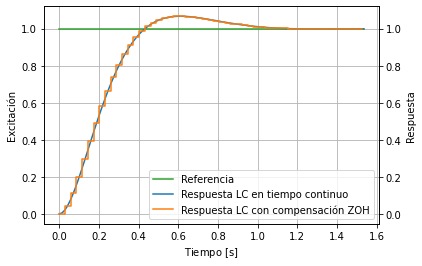

In [17]:
from utils.ctrlsys import step, zoh_stairs
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

plot_step(gcl_tf, label="Respuesta LC en tiempo continuo")
plot_step(gclc_dtf, label="Respuesta LC con compensación ZOH")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")

fig.savefig(out_dir / "1p4_resp_zoh.svg")

In [18]:
from utils.ctrlsys import difference_eq
from utils.ctrl import siso_numden

difference_eq$(
    *siso_numden(gcc_dtf))$(
    *map(sp.Function, ["e", "u"]))(
    sp.Symbol("k")).n(4)

Eq(u(k), 0.5185*e(k) - 0.4279*e(k - 1) + 0.6637*u(k - 2) - 0.3363*u(k - 1))

In [19]:
ts = 1*u.s
mp = 7*u.percent

In [20]:
from utils.ctrlsys import pole_specs

_, dp_s = pole_specs(nu[ts], nu[mp])
nu.to_symb(u.Hz, dp_s).n(4)

hertz*(-3.912 + 4.622*I)

In [21]:
from utils.ctrlsys import z_map
dp = z_map(dp_s, nu[dt_])
sp.sympify(dp).n(4)

0.8856 + 0.1185*I

In [22]:
gdelay_dtf = 1/m.tf("z")

gls = {
    "atraso del muestreador": gdelay_dtf,
    "planta": gp_dtf
}

In [23]:
# Try removing `real=True` and see what a
# friendly error message you get with `sp.nsolve`
k, pl, zl = sp.symbols("K P_l Z_l", real=True)

gc_dc = k*(z-zl)/(z-pl)
gc_dc

K*(-Z_l + z)/(-P_l + z)

In [24]:
zl_ = min(gp_dtf.pole())
gc_dc_ = gc_dc.subs(zl, zl_)
zl_

0.8659817180406106

In [25]:
from utils.ratpolys import numden2ratpoly

def rlocus_cond(dp, z, ratpoly):
    return ratpoly.subs(z, dp)+1

gp_d = numden2ratpoly$(*siso_numden(gp_dtf))(z)
gp_d

(0.0829336593441887*z + 0.0790503135693692)/(1.0*z**2 - 1.86598171804061*z + 0.86598171804061)

In [26]:
from utils.math import sp_reim
from utils.misc import valmap
from more_itertools import one

k_, pl_ = sp.nsolve(
    sp_reim(rlocus_cond(dp, z, gp_d*gc_dc_/z)),
    (k, pl), (1, .5)
) |> map$(float)
k_, pl_

(0.1702433228738177, 0.7544105069559)

In [27]:
from utils.ctrlsys import autotune

k_, pl_ = autotune({k: k_, pl: pl_},
    z, m.tf("z"),
    gc_dc_,
    nu[mp]*.95, nu[ts]*.95,
    reduce((*), gls.values()),
    1, iter=100)
k_, pl_

(0.19602593445073657, 0.7316288503343901)

In [28]:
gc_dctf = my_expr2sys(gc_dc_.subs({k: k_, pl: pl_}), z)
gc_dctf

TransferFunction(array([ 0.19602593, -0.16975488]), array([ 1.        , -0.73162885]), True)

In [29]:
gcl_dctf = m.feedback(reduce((*), gls.values())*gc_dctf)
gcl_dctf

TransferFunction(array([ 0.01625715,  0.00141752, -0.01341918]), array([ 1.        , -2.59761057,  2.24744493, -0.63215969, -0.01341918]), 0.002169455779068741)

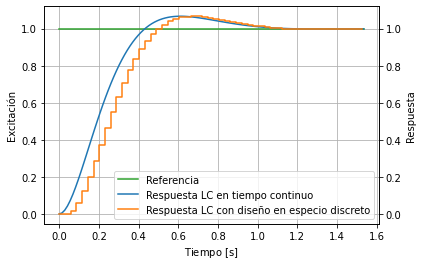

In [30]:
from utils.ctrlsys import step, zoh_stairs
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)

plot_step(gcl_tf, label="Respuesta LC en tiempo continuo")
plot_step(gcl_dctf, label="Respuesta LC con diseño en especio discreto")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")

fig.savefig(out_dir / "2p2_resp_zdes.svg")

In [31]:
nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_dctf))

{'RiseTime': 0.316561259190327*second,
 'SettlingTime': 0.978462073861009*second,
 'SettlingMin': 0.931792637979566,
 'SettlingMax': 1.06649999999993,
 'Overshoot': 6.64999999997738*percent,
 'Undershoot': 0,
 'Peak': 1.06649999999993,
 'PeakTime': 0.661900814670683*second,
 'SteadyStateValue': 1.00000000000015}